# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import json
df1 = pd.read_csv("twitter-archive-enhanced.csv")

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

***I try to use 'Request' to download the url, but failed, due to China network cannot reach the url.***

In [ ]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
folder_name = 'new_folder'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

### Instead, I just download the "image-predictions.tsv" and read the file into Dataframe df2

In [2]:
df2 = pd.read_csv("image-predictions.tsv",sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)
***China network also cannot reach the Twitter.So I only copy the code below***

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

### Instead, I just download the "tweet-json.txt" and read everyline in this file into Dataframe df3 with tweet ID, retweet count, and favorite count.

In [3]:
df_list = []
with open ('tweet-json.txt',encoding='utf-8') as file:
    for line in file:
        jsonData = file.readline()
        content = json.loads(jsonData)
        tweet_id = content['id']
        retweet_count = content['retweet_count']
        favorite_count = content['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                        'retweet_count':retweet_count,
                        'favorite_count':favorite_count})
df3 = pd.DataFrame(df_list)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

**Quality issues definition:**

- Non-descriptive column headers
- Missing values (i.e., NaNs)
- Inconsistent representations of values, specifically "As soon as possible" and other similar values to "ASAP" in the StartDate column for this dataset
- A messy (i.e., untidy) dataset


### Quality issues

#### In the file <twitter-archive-enhanced.csv>
    1.the column "in_reply_to_status_id" and "in_reply_to_user_id" only have 78 non-null data
        retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp, only have 181 non-null data
    2.the column "expanded_urls" only have 2297 non-null object, it means have null value in this column
    3.the column "rating_numerator" have very big number,"rating_denominator" have the value not equal to 10
    4.the column "name" cotains the word not the dog name, for example 'a'
    5.the column "timestamp" and "retweeted_status_timestamp" cotains the "0000" which should be delete
    6.the column "expanded urls" contains dupilicated urls
    7.source column contains a lot of useless information which need be delete
#### In the file <image-predictions.tsv>
    8.the "jpg_url" column have duplicated urls


### Tidiness issues
    1.In "twitter-archive-enhanced.csv" the column [doggo],[floofer],[pupper],[puppo] are the different stage of dog which should be one variable, but not 4 columns.

    2.The "twitter-archive-enhanced.csv", "image-predictions.tsv","tweet-json.txt" describe the same variable should be in one table

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

- each variable is a column
- each observation is a row
- each type of observational unit is a table.

In [5]:
# Make copies of original pieces of data
df1_copy = df1.copy()
df2_copy = df2.copy()
df3_copy = df3.copy()

### Quality Issue #1:

#### Define:
    Drop the below columns:
- in_reply_to_status_id
- in_reply_to_user_id
- retweeted_status_id
- retweeted_status_user_id
- retweeted_status_timestamp

#### Code

In [6]:
df1_copy = df1_copy.drop(columns = ["in_reply_to_status_id","in_reply_to_user_id","retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"],axis=1)

#### Test

In [7]:
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


### Quality Issue #2:

#### Define
    Drop the NA row of the column "expanded_urls"

#### Code

In [8]:
df1_copy = df1_copy[df1_copy.expanded_urls.notnull()]

#### Test

In [9]:
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2297 non-null   int64 
 1   timestamp           2297 non-null   object
 2   source              2297 non-null   object
 3   text                2297 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2297 non-null   int64 
 6   rating_denominator  2297 non-null   int64 
 7   name                2297 non-null   object
 8   doggo               2297 non-null   object
 9   floofer             2297 non-null   object
 10  pupper              2297 non-null   object
 11  puppo               2297 non-null   object
dtypes: int64(3), object(9)
memory usage: 233.3+ KB


### Quality Issue #3:

#### Define
    Drop the row of big number in the column "rating_numerator", Drop the "rating_denominator" !=10

#### Code

In [10]:
df1_copy = df1_copy[(df1_copy.rating_numerator<=20)&(df1_copy.rating_denominator==10)]

#### Test

In [11]:
df1_copy.rating_numerator.value_counts(),df1_copy.rating_denominator.value_counts()

(12    547
 11    455
 10    455
 13    339
 9     154
 8     102
 7      52
 14     50
 5      35
 6      32
 3      19
 4      15
 2       9
 1       5
 0       2
 15      1
 Name: rating_numerator, dtype: int64,
 10    2272
 Name: rating_denominator, dtype: int64)

### Quality Issue #4:

#### Define
    replace the dog name from 'a' to 'None', in the column 'name'.

#### Code

In [12]:
df1_copy.name = df1_copy.name.replace('a','None')

#### Test

In [13]:
df1_copy.name.value_counts()

None          725
Charlie        12
Cooper         11
Lucy           11
Oliver         11
             ... 
Gert            1
Dex             1
Ace             1
Tayzie          1
Christoper      1
Name: name, Length: 952, dtype: int64

### Quality Issue #5:
#### Define
    Delete the '0000' in the column "timestamp" and convert to the type "datetime64" in Dataframe

#### Code

In [14]:
df1_copy.timestamp = pd.to_datetime(df1_copy.timestamp.str[:-5].str.strip())

#### Test

In [15]:
df1_copy.timestamp

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2351   2015-11-16 00:24:50
2352   2015-11-16 00:04:52
2353   2015-11-15 23:21:54
2354   2015-11-15 23:05:30
2355   2015-11-15 22:32:08
Name: timestamp, Length: 2272, dtype: datetime64[ns]

### Quality Issue #6:

###### Define
    Delete the dupilicated urls the column "expanded_urls"

#### Code

In [15]:
df1_copy.expanded_urls = df1_copy.expanded_urls.str.split(',',expand=True)[0]

#### Test

In [16]:
assert ',' not in df1_copy.expanded_urls.values

### Quality Issue #7:

###### Define
    extract the source information between ">" and "<"

#### Code

In [17]:
df1_copy.source = df1_copy.source.str.extract('>(.*)<',expand=False)

#### Test

In [18]:
df1_copy.source.value_counts()

Twitter for iPhone     2139
Vine - Make a Scene      91
Twitter Web Client       32
TweetDeck                10
Name: source, dtype: int64

### Quality Issue #8:

###### Define
     Delete the dulicated jpg_url in the table "image-predictions.tsv"

#### Code

In [19]:
df2_copy.drop_duplicates('jpg_url',inplace = True)

#### Test

In [20]:
sum(df2_copy.jpg_url.duplicated())

0

### Tideness Issue #1:

###### Define
    1. Create a new column "stage" in df1_copy.
    2. Find the stage data in the df1_clean.text, with different category [doggo],[floofer],[pupper],[puppo]
    3. Drop the original column [doggo],[floofer],[pupper],[puppo]

#### Code

In [21]:
df1_copy['stage'] = df1_copy.text.str.lower().str.findall(r'(doggo|floofer|pupper|puppo)')
df1_copy['stage'] = df1_copy.stage.apply(lambda x:set(x))
df1_copy['stage'] = df1_copy.stage.apply(lambda x:'|'.join(x))
df1_copy['stage'] = df1_copy.stage.replace('',np.nan)
df1_copy.drop(['doggo','floofer','pupper','puppo'],axis=1,inplace = True)

#### Test

In [22]:
df1_copy['stage'].value_counts()

pupper           260
doggo             88
puppo             33
doggo|pupper      12
floofer            9
doggo|puppo        2
doggo|floofer      1
Name: stage, dtype: int64

In [23]:
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2272 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2272 non-null   int64         
 1   timestamp           2272 non-null   datetime64[ns]
 2   source              2272 non-null   object        
 3   text                2272 non-null   object        
 4   expanded_urls       2272 non-null   object        
 5   rating_numerator    2272 non-null   int64         
 6   rating_denominator  2272 non-null   int64         
 7   name                2272 non-null   object        
 8   stage               405 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 177.5+ KB


### Tideness Issue #2:

###### Define
    1. Create a new column "rating" in df1_copy, rating = rating_numerator/rating_denominator
    2. Drop the "rating_numerator" and "df1_copy2.rating_denominator"

#### Code

In [24]:
df1_copy["rating"] = (df1_copy.rating_numerator/df1_copy.rating_denominator).astype('float')
df1_copy.drop(["rating_numerator","rating_denominator"],axis=1,inplace=True)

In [25]:
df1_copy["rating"]

0       1.3
1       1.3
2       1.2
3       1.3
4       1.2
       ... 
2351    0.5
2352    0.6
2353    0.9
2354    0.7
2355    0.8
Name: rating, Length: 2272, dtype: float64

In [26]:
df1_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2272 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tweet_id       2272 non-null   int64         
 1   timestamp      2272 non-null   datetime64[ns]
 2   source         2272 non-null   object        
 3   text           2272 non-null   object        
 4   expanded_urls  2272 non-null   object        
 5   name           2272 non-null   object        
 6   stage          405 non-null    object        
 7   rating         2272 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 159.8+ KB


### Tideness Issue #3:

###### Define
    Merge all the 3 tables together to 1 table

#### Code

In [27]:
df_final = df1_copy.merge(df2_copy,how='inner',on='tweet_id')
df_final = df_final.merge(df3_copy,how='left',on='tweet_id')

#### Test

In [28]:
df_final.head()

,tweet_id,timestamp,source,text,expanded_urls,name,stage,rating,jpg_url,img_num,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,NaN,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,Tilly,NaN,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,Archie,NaN,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,Darla,NaN,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,Franklin,NaN,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,NaN,NaN


In [29]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   tweet_id        1986 non-null   int64         
 1   timestamp       1986 non-null   datetime64[ns]
 2   source          1986 non-null   object        
 3   text            1986 non-null   object        
 4   expanded_urls   1986 non-null   object        
 5   name            1986 non-null   object        
 6   stage           336 non-null    object        
 7   rating          1986 non-null   float64       
 8   jpg_url         1986 non-null   object        
 9   img_num         1986 non-null   int64         
 10  p1              1986 non-null   object        
 11  p1_conf         1986 non-null   float64       
 12  p1_dog          1986 non-null   bool          
 13  p2              1986 non-null   object        
 14  p2_conf         1986 non-null   float64       
 15  p2_d

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [30]:
df_final.to_csv("twitter_archive_master.csv")

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

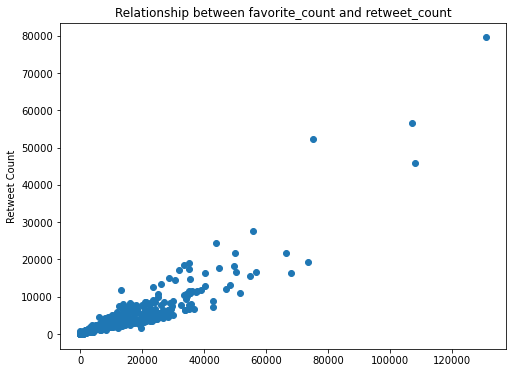

In [101]:
plt.figure(figsize=(8,6)) 
plt.scatter(df_final.favorite_count,df_final.retweet_count);
#plt.xlabel('Favorite Count');
plt.ylabel('Retweet Count');
plt.title('Relationship between favorite_count and retweet_count');

In [86]:
df_final.rating.describe()

count    1986.000000
mean        1.055891
std         0.218900
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max         1.500000
Name: rating, dtype: float64

In [87]:
df_final.rating.value_counts()

1.2    455
1.0    421
1.1    397
1.3    264
0.9    150
0.8     95
0.7     51
1.4     37
0.5     34
0.6     32
0.3     19
0.4     15
0.2      9
0.1      4
0.0      2
1.5      1
Name: rating, dtype: int64

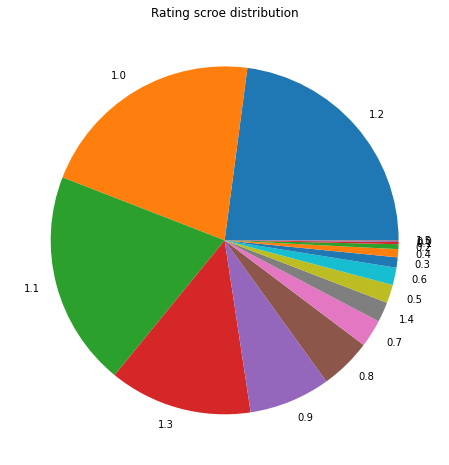

In [109]:
rating_score = df_final.rating.value_counts()
plt.figure(figsize=(8,8));
plt.title("Rating scroe distribution");
plt.pie(rating_score,labels=rating_score.index);

In [124]:
s13 = df_final[df_final.rating ==1.3].retweet_count.sum()
s12 = df_final[df_final.rating ==1.2].retweet_count.sum()
s11 = df_final[df_final.rating ==1.1].retweet_count.sum()
s10 = df_final[df_final.rating ==1.0].retweet_count.sum()
s09 = df_final[df_final.rating ==0.9].retweet_count.sum()
s08 = df_final[df_final.rating ==0.8].retweet_count.sum()
s07 = df_final[df_final.rating ==0.7].retweet_count.sum()
s06 = df_final[df_final.rating ==0.6].retweet_count.sum()
s05 = df_final[df_final.rating ==0.5].retweet_count.sum()

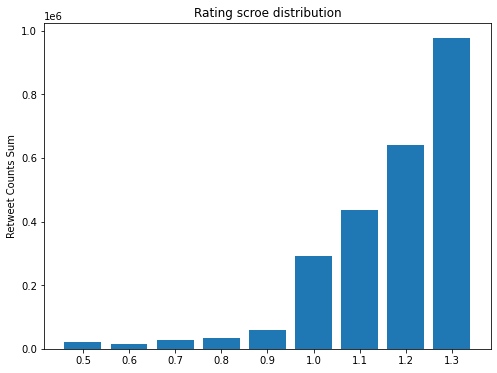

In [125]:
x=[1,2,3,4,5,6,7,8,9]
y=[s05,s06,s07,s08,s09,s10,s11,s12,s13]
x_label=['0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3']
plt.figure(figsize=(8,6));
plt.xticks(x, x_label);
plt.title("Rating scroe distribution");
#plt.xlabel('Rating Scroe');
plt.ylabel('Retweet Counts Sum');
plt.bar(x,y);

### Insights:
1. The more people love this tweet, the more times it is retweeted

2. The rating score for the dog distribute mostly between 0.7 - 1.3 (9/10 to 13/10)

3. The more rating socre of the dog, the more times it is retweeted (From 5/10 to 13/10)

### Visualization